In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


'dx' is short for diagnosis (for the patient)
- 'nv': 'Melanocytic nevi'
- 'mel': 'Melanoma'
- 'bkl': 'Benign keratosis-like lesions'
- 'bcc': 'Basal cell carcinoma'
- 'akiec': 'Actinic keratoses'
- 'vasc': 'Vascular lesions'
- 'df': 'Dermatofibroma'

'dx_type' is how the diagnosis was made. 
- histo        5340
- follow_up    3704
- consensus     902
- confocal       69

In [2]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [3]:
import pandas as pd
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def disease_to_label(l):
    if l == "akiec":
        return 0
    if l == "bcc":
        return 1
    if l == "bkl":
        return 2
    if l == "df":
        return 3
    if l == "mel":
        return 4
    if l == "nv":
        return 5
    if l == "vasc":
        return 6 

class SkinCancerDetection_train(Dataset):
    
    def __init__(self, train_path, csv, transform=None):
        self.train_path = train_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+27306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        p = os.path.join(self.train_path, image_file_name)

        img = plt.imread(p)


        if self.transform:
            img = self.transform(img)
        
        return img, label
    
class SkinCancerDetection_test(Dataset):
    
    def __init__(self, test_path, csv, transform=None):
        self.test_path = test_path
        self.csv_path = csv
        self.transform = transform
    def __len__(self):
        df = pd.read_csv(self.csv_path)
        return (len(df.index))
    def __getitem__(self, idx):
        image_id = "ISIC_00" + str(idx+24306)
        image_file_name = image_id + ".jpg"
        df = pd.read_csv(self.csv_path)
        label = disease_to_label(str(df.loc[df['image_id'] == image_id, 'dx'].item()))
        
        p = os.path.join(self.test_path, image_file_name)
        
        img = plt.imread(p)
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [4]:
train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.25),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            transforms.RandomErasing(p=0.1, value='random')
        ])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD) # imagenet means
])

train_ds = SkinCancerDetection_train('../../kaggle/input/HAM10000_images_train','../../kaggle/input/HAM10000_metadata_train.csv',transform=train_transform)
val_ds = SkinCancerDetection_test('../../kaggle/input/HAM10000_images_test','../../kaggle/input/HAM10000_metadata_test.csv',transform=test_transform)

In [5]:
len(val_ds)

3000

## Split train and validation dataset
- batch_size = 64



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


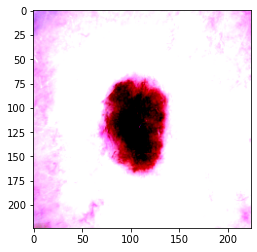

tensor(5)


In [6]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
torch.manual_seed(random_seed)

# batch_size = 128
batch_size = 64 

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

plt.figure()

for image, label in train_dl:
    plt.imshow(image[0].permute(2, 1, 0))
    print(type(image[0]))
    plt.show()
    print(label[0])
    break

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [8]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [9]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
swin_tiny_patch4_window7_224 = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in /home/jujie/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main
/home/jujie/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
model = to_device(swin_tiny_patch4_window7_224, device)
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

In [11]:
from sklearn.metrics import precision_recall_fscore_support

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def training_step(criterion, model,batch):
    images, labels = batch 
    out = model(images)                  # Generate predictions
    loss = criterion(out, labels)  # criterion is already to device GPU
    return loss

def validation_step(criterion, model,batch):
    images, labels = batch 
    out = model(images)                    # Generate predictions

    loss = criterion(out, labels)   # Calculate loss
    
#     ---------------- why here acc not to(device)
    acc = accuracy(out, labels)           # Calculate accuracy (return a tensor)
    
#     ------------------- calculate fscore for each batch ----------------

    _, y_preds = torch.max(out, dim=1)    
    threeMetrics = precision_recall_fscore_support(torch.Tensor.cpu(labels), torch.Tensor.cpu(y_preds), average=None,labels=[i for i in range(7)])
    fscore = torch.tensor(threeMetrics[2]) # fscore (return a tensor of a list: tensor([1,2,3]))
    
    return {'val_loss': loss.detach(), 'val_acc': acc, 'val_fscore': fscore}
    
def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs] 
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses (mean loss for n batches)
    
    batch_accs = [x['val_acc'] for x in outputs]   # [ each element is a tensor ]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies (mean acc for n batches)
    
    batch_fscores = [x['val_fscore'] for x in outputs] 
    epoch_fscore = torch.stack(batch_fscores).mean(0)
    
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_fscore': epoch_fscore.tolist()}

def epoch_end(epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_fscore: {} ".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['val_fscore']))

In [12]:
# criterion = LabelSmoothingCrossEntropy()
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
criterion = criterion.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

In [13]:
@torch.no_grad()
def evaluate(criterion, model, val_loader):
    model.eval()
    outputs = [validation_step(criterion, model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def fit_one_cycle(num_epochs, model, train_loader, val_loader, optimizer, criterion):
    torch.cuda.empty_cache()
    history = []
    
    # sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-6, last_epoch=- 1, verbose=False)
    
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = training_step(criterion,model,batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(criterion, model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
history = [evaluate(criterion, model, valid_dl)]
history

[{'val_loss': 6.037652492523193,
  'val_acc': 0.0055338540114462376,
  'val_fscore': [0.0,
   0.0,
   0.0,
   0.0,
   0.006944444444444445,
   0.014764199725085254,
   0.0]}]

In [16]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.9846, val_loss: 1.7405, val_acc: 0.7190, val_fscore: [0.0, 0.0, 0.40943666698351344, 0.0, 0.16457479747920925, 0.8523469347693347, 0.0] 
Epoch [1], train_loss: 1.7877, val_loss: 1.7857, val_acc: 0.6987, val_fscore: [0.1720899470899471, 0.3426820986281968, 0.01851851851851852, 0.0, 0.014467592592592593, 0.8565187558954107, 0.0] 
Epoch [2], train_loss: 1.7281, val_loss: 1.6824, val_acc: 0.7347, val_fscore: [0.3063388000888001, 0.04047619047619048, 0.3909385574611377, 0.0, 0.2235206238979459, 0.8742355885443246, 0.0] 
Epoch [3], train_loss: 1.6858, val_loss: 1.6013, val_acc: 0.7620, val_fscore: [0.4446900866018513, 0.4746825114341628, 0.529481910373158, 0.0, 0.27287459952901133, 0.9012783571776314, 0.2222222222222222] 


In [17]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.6376, val_loss: 1.6405, val_acc: 0.7468, val_fscore: [0.35823703801644985, 0.49111441720810406, 0.24388569470343593, 0.0, 0.405239877225386, 0.8845642738836915, 0.31249999999999994] 
Epoch [1], train_loss: 1.6129, val_loss: 1.5791, val_acc: 0.7913, val_fscore: [0.44329397454397457, 0.641460507801452, 0.48024468723817476, 0.0, 0.3682769303342395, 0.9011714431725343, 0.725] 
Epoch [2], train_loss: 1.5747, val_loss: 1.5244, val_acc: 0.7925, val_fscore: [0.4673375779993427, 0.6344579696195828, 0.56414023164148, 0.0, 0.50874421249534, 0.9028568426725802, 0.669047619047619] 
Epoch [3], train_loss: 1.5360, val_loss: 1.5391, val_acc: 0.7920, val_fscore: [0.4906670266867635, 0.7122200880618063, 0.34948959396184803, 0.07916666666666666, 0.43081192015646513, 0.8891720025227983, 0.699537037037037] 


In [18]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.5255, val_loss: 1.5029, val_acc: 0.8075, val_fscore: [0.44117673584585354, 0.5971677652570663, 0.6000287048442016, 0.15833333333333333, 0.4380844695988518, 0.9132319391841709, 0.7301587301587301] 
Epoch [1], train_loss: 1.4873, val_loss: 1.5253, val_acc: 0.7983, val_fscore: [0.4541755949364645, 0.6795354967778916, 0.526299340088971, 0.11666666666666665, 0.3588058258820643, 0.9085775734196545, 0.763888888888889] 
Epoch [2], train_loss: 1.4526, val_loss: 1.5927, val_acc: 0.7854, val_fscore: [0.33424723424723424, 0.4963782250568007, 0.5654571838458572, 0.020833333333333332, 0.3389176251308605, 0.9137952697334951, 0.5880050505050505] 
Epoch [3], train_loss: 1.4811, val_loss: 1.5459, val_acc: 0.7874, val_fscore: [0.0, 0.55386614698952, 0.5238541720289908, 0.08333333333333333, 0.5017221996679802, 0.9108877299538586, 0.7922619047619047] 


In [19]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.4496, val_loss: 1.4861, val_acc: 0.8132, val_fscore: [0.41379890534302294, 0.706897766091887, 0.5687748337271212, 0.08333333333333333, 0.5575039710234462, 0.9112846698773938, 0.7732142857142859] 
Epoch [1], train_loss: 1.4066, val_loss: 1.5215, val_acc: 0.8022, val_fscore: [0.5085301396068322, 0.578609329267224, 0.5607184435116596, 0.1773809523809524, 0.4143739153433425, 0.9176757037062518, 0.5643939393939393] 
Epoch [2], train_loss: 1.4006, val_loss: 1.4927, val_acc: 0.8065, val_fscore: [0.4944030506530506, 0.6948851801792978, 0.5660723469242069, 0.26157407407407407, 0.48594977251157223, 0.9109664588439341, 0.7055555555555554] 
Epoch [3], train_loss: 1.3611, val_loss: 1.4675, val_acc: 0.8214, val_fscore: [0.6314292676134782, 0.6531937360884729, 0.637132549168693, 0.2883928571428571, 0.5286380699605057, 0.9169466719849756, 0.6972222222222221] 


In [24]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.3663, val_loss: 1.4443, val_acc: 0.8372, val_fscore: [0.5704517765373028, 0.7216995943338654, 0.6087653332400401, 0.15833333333333333, 0.5369982925627191, 0.9236582597717118, 0.7496031746031746] 
Epoch [1], train_loss: 1.3602, val_loss: 1.5388, val_acc: 0.8129, val_fscore: [0.5435701621363386, 0.6861089298415148, 0.5861375534085939, 0.27559523809523806, 0.2896209525226721, 0.9153212424606624, 0.5166666666666667] 
Epoch [2], train_loss: 1.3369, val_loss: 1.5260, val_acc: 0.8251, val_fscore: [0.4129525294966472, 0.6286179585521691, 0.6178493245888395, 0.27321428571428574, 0.5261303013722749, 0.9193847790496589, 0.7388888888888889] 
Epoch [3], train_loss: 1.3121, val_loss: 1.5533, val_acc: 0.8202, val_fscore: [0.47858784733784737, 0.6828727440859793, 0.6478123491074878, 0.2736111111111111, 0.29342591604588514, 0.9164030961398805, 0.7588585434173668] 


In [29]:
num_epochs=4
history += fit_one_cycle(num_epochs, model, train_dl, valid_dl, optimizer, criterion)

Epoch [0], train_loss: 1.3212, val_loss: 1.4908, val_acc: 0.8285, val_fscore: [0.5499484798826905, 0.7021809125263493, 0.635839547477102, 0.27529761904761907, 0.5717639269508072, 0.9178053845397458, 0.6819444444444445] 
Epoch [1], train_loss: 1.3094, val_loss: 1.4591, val_acc: 0.8299, val_fscore: [0.5693302952494129, 0.6541711549257988, 0.6286038196767666, 0.09999999999999999, 0.5488142522336725, 0.92895104526401, 0.780485527544351] 
Epoch [2], train_loss: 1.2835, val_loss: 1.5018, val_acc: 0.8286, val_fscore: [0.5857012268776974, 0.7207449397300824, 0.6391966088923531, 0.2845238095238095, 0.5152690301598993, 0.9215285751404009, 0.7412990196078432] 
Epoch [3], train_loss: 1.2662, val_loss: 1.4899, val_acc: 0.8232, val_fscore: [0.5546759011542294, 0.7080280481335469, 0.6303218999965137, 0.23124999999999998, 0.47229821315869236, 0.9163272999982621, 0.544949494949495] 


In [30]:
# torch.save(model.state_dict(), 'deit_tiny_patch16_224.pth')
torch.save(model.state_dict(), '../../kaggle/ubuntu_save_model/ubuntu_sourceCode_size73_swin_tiny_patch4_window7_224.pth')

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

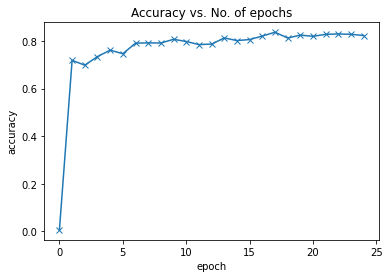

In [32]:
plot_accuracies(history)

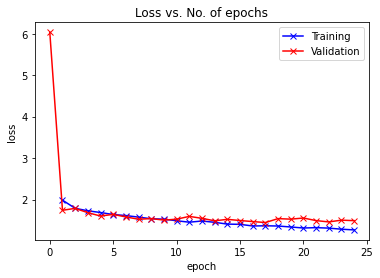

In [33]:
plot_losses(history)